# Theme 2 - Climate Variability, Ocean Circulation, and Ecosystem
## Global Biogeochemistry and Carbon Cycling
OOI Data Labs Education Nuggets

**Objective**: Demonstrate how to download chlorophyll-a data from the OOI system using the Machine-to-Machine (M2M) interface and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

* **Global Irminger Sea** - Chlorophyll-a data from both Flanking Moorings
    * Instruments:
        * Irminger Flanking Mooring A Fluorometer: GI03FLMA-RIS01-05-FLORTD000
        * Irminger Flanking Mooring B Fluorometer: GI03FLMB-RIS01-05-FLORTD000
    * Time range: 2014-09-01 to 2015-09-01
    * Delivery method, data stream, and parameter name: recovered_host, flort_sample, fluorometric_chlorophyll_a
* **Global Argentine Basin** - Chlorophyll-a data from the Surface Mooring at 12m depth
    * Instrument: GA01SUMO-RID16-02-FLORTD000
    * Time range: 2015-03-15 to 2018-01-15
    * Delivery method, data stream, and parameter name: recovered_host, flort_sample, fluorometric_chlorophyll_a

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for the three instruments of interest. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# GI03FLMA_url = request_data('GI03FLMA-RIS01-05-FLORTD000', 'recovered_host', 'flort_sample',
#                             '2014-09-01T00:00:00.000Z', '2015-09-01T00:00:00.000Z')
# 
# GI03FLMB_url = request_data('GI03FLMB-RIS01-05-FLORTD000', 'recovered_host', 'flort_sample',
#                             '2014-09-01T00:00:00.000Z', '2015-09-01T00:00:00.000Z')
# 
# GA01SUMO_url = request_data('GA01SUMO-RID16-02-FLORTD000', 'recovered_host', 'flort_sample',
#                             '2015-03-15T00:00:00.000Z', '2018-01-15T00:00:00.000Z')
# print('GI03FLMA_url = %s' %GI03FLMA_url)
# print('GI03FLMB_url = %s' %GI03FLMB_url)
# print('GA01SUMO_url  %s' %GA01SUMO_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations.

In [5]:
GI03FLMA_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20190809T155426809Z-GI03FLMA-RIS01-05-FLORTD000-recovered_host-flort_sample/catalog.html'
GI03FLMB_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20190809T155427737Z-GI03FLMB-RIS01-05-FLORTD000-recovered_host-flort_sample/catalog.html'
GA01SUMO_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20190809T155428629Z-GA01SUMO-RID16-02-FLORTD000-recovered_host-flort_sample/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files and removing collocated datasets (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, vars):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in vars:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in vars:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)

    return df, unit_dict

In [7]:
# Specify the variable(s) of interest and get the data for the three datasets
variables = ['fluorometric_chlorophyll_a']

GI03FLMA_data, GI03FLMA_units = get_data(GI03FLMA_url, variables)
GI03FLMB_data, GI03FLMB_units = get_data(GI03FLMB_url, variables)
GA01SUMO_data, GA01SUMO_units = get_data(GA01SUMO_url, variables)
print(GI03FLMA_units)

{'fluorometric_chlorophyll_a': ['µg L-1']}


## Quick Data Plots
Make quick plots to make sure you downloaded the correct data.

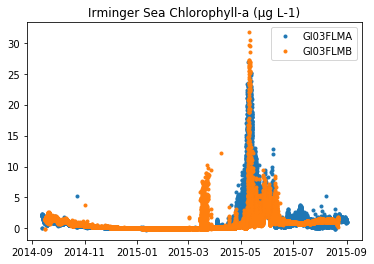

In [8]:
# Plot the Irminger Sea data
fig, ax = plt.subplots()
plt.plot(GI03FLMA_data['time'], GI03FLMA_data['fluorometric_chlorophyll_a'], '.', label='GI03FLMA')
plt.plot(GI03FLMB_data['time'], GI03FLMB_data['fluorometric_chlorophyll_a'], '.', label='GI03FLMB')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Irminger Sea Chlorophyll-a ({})'.format(GI03FLMA_units['fluorometric_chlorophyll_a'][0]));

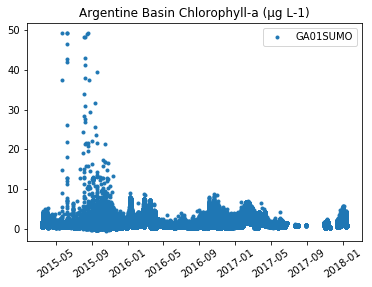

In [9]:
# Plot the Argentine Basin data - this may take a while because there are 3 years of data to plot
fig, ax = plt.subplots()
plt.plot(GA01SUMO_data['time'], GA01SUMO_data['fluorometric_chlorophyll_a'], '.', label='GA01SUMO')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Argentine Basin Chlorophyll-a ({})'.format(GA01SUMO_units['fluorometric_chlorophyll_a'][0]))
plt.xticks(rotation=35);

It looks like there are some extreme chlorophyll values in the Argentine Basin data in 2015. From the Data Review Report [here](https://datareview.marine.rutgers.edu/instruments/report/GA01SUMO-RID16-02-FLORTD000) it looks like data from 9/1/2015 to 11/1/2015 are suspect so we will need to remove those data before creating the final .csv file.

## 3. Merge and export
We will need to merge the Irminger Sea dataframes to export those data to one .csv file. The fluorometers on the Global Flanking Moorings take one sample every 15 minutes, and since we downloaded a relatively short time frame (1 year) we can export the full dataset. For the Argentine Basin data, we will first calculate hourly averages to make the dataset more manageable (the sampling rates are higher for the fluorometers on the Global Surface Moorings, and the time range we selected is longer), then filter out the suspect data range.

In [10]:
# Merge the Irminger Sea dataframes
# cut off the seconds in the time stamp
GI03FLMA_data['time'] = GI03FLMA_data['time'].apply(lambda t: t.strftime('%Y-%m-%d %H:%M'))
GI03FLMB_data['time'] = GI03FLMB_data['time'].apply(lambda t: t.strftime('%Y-%m-%d %H:%M'))

# rename and add units to the columns
GI03FLMA_data = GI03FLMA_data.rename(columns={'fluorometric_chlorophyll_a': 'GI03FLMA Chlorophyll ({})'.format(
    GI03FLMA_units['fluorometric_chlorophyll_a'][0])})
GI03FLMB_data = GI03FLMB_data.rename(columns={'fluorometric_chlorophyll_a': 'GI03FLMB Chlorophyll ({})'.format(
    GI03FLMB_units['fluorometric_chlorophyll_a'][0])})

# merge the dataframes and export to csv
merged = pd.merge(GI03FLMA_data, GI03FLMB_data, on='time', how='outer')
merged = merged.sort_values('time').reset_index(drop=True)  # make sure the dataframe is sorted by time

In [11]:
# export to csv
merged.to_csv(os.path.join(save_dir, 'Theme2c_Irminger_chla.csv'), index=False)

In [12]:
# Modify the Argentine Basin dataframe
# rename and add units to the columns
GA01SUMO_data = GA01SUMO_data.rename(columns={'fluorometric_chlorophyll_a': 'GA01SUMO Chlorophyll ({})'.format(
    GA01SUMO_units['fluorometric_chlorophyll_a'][0])})

# calculate hourly averages
GA01SUMO_df_hourly = GA01SUMO_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# filter out suspect time range
GA01SUMO_filt = GA01SUMO_df_hourly.loc[(GA01SUMO_df_hourly['time'] < '9-1-2015') | (GA01SUMO_df_hourly['time'] > '11-1-2015')]

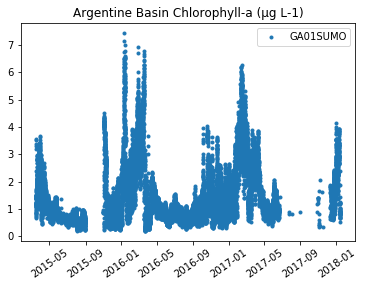

In [13]:
# Plot the Argentine Basin data again to make sure the suspect data were removed
fig, ax = plt.subplots()
plt.plot(GA01SUMO_filt['time'], GA01SUMO_filt['GA01SUMO Chlorophyll (µg L-1)'], '.', label='GA01SUMO')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Argentine Basin Chlorophyll-a ({})'.format(GA01SUMO_units['fluorometric_chlorophyll_a'][0]))
plt.xticks(rotation=35);

In [14]:
# Looks much better! Export the final dataset to csv
GA01SUMO_filt.to_csv(os.path.join(save_dir, 'Theme2c_ArgentineBasin_chla.csv'), index=False)